In [1]:
# based on <https://github.com/leelabcnbc/thesis-yimeng-v1/blob/master/results_ipynb/yuanyuan_8k_a_3day/transfer_learning_factorized_vgg.ipynb>

In [2]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from functools import partial

pd.set_option('display.max_rows', 999)

In [3]:
from torchnetjson.builder import build_net

In [4]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished.builder import load_modules

load_modules()

In [5]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/maskcnn_polished'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit import param_iterator_obj
from key_utils import keygen

In [6]:
from thesis_v2.training_extra.data import generate_datasets
from thesis_v2.training_extra.evaluation import eval_fn_wrapper as eval_fn_wrapper_neural
from thesis_v2.training.training import eval_wrapper
from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_neural_data

from torch.backends import cudnn
import torch
cudnn.enabled = True
cudnn.deterministic = True
cudnn.benchmark = False

_data_cache = dict()

def get_data_cached(input_size, seed):
    if (input_size, seed) not in _data_cache:
        _data_cache[input_size, seed] = get_data('a', 200, input_size,
                                                 ('042318', '043018', '051018'),
                                                 scale=0.5,
                                                 seed=seed)
    return _data_cache[input_size, seed]

def load_maskcnn_result(param, verbose):
    # this is tricky, because I did not save per neuron corr during training.
    # shit.
    #
    # afterwards, I will simply save thoese perneuron corr.
    # 
    # right now, let's load the data set and do the evaluation again.
    assert param['out_channel'] == 16
    assert param['num_layer'] == 2
    assert param['kernel_size_l1'] == 9
    assert param['pooling_ksize'] == 3
    assert param['pooling_type'] == 'avg'

    assert param['model_seed'] == 0

    key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
    result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
    result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
    
    # then create data set.
#     datasets = get_data('a', 200, param['input_size'], ('042318', '043018', '051018'), scale=0.5,
#                         seed=param['split_seed'])
    datasets = get_data_cached(param['input_size'], param['split_seed'])

    
    datasets = {
        'X_train': datasets[0].astype(np.float32),
        'y_train': datasets[1],
        'X_val': datasets[2].astype(np.float32),
        'y_val': datasets[3],
        'X_test': datasets[4].astype(np.float32),
        'y_test': datasets[5],
    }
    
    # only the test one is needed.
    datasets = generate_datasets(
        **datasets,
        per_epoch_train=True, shuffle_train=True,
    )['test']
    
    result_on_the_go = eval_wrapper(result['model'].cuda(),
                                    datasets,
                                    'cuda',
                                    1,
                                    partial(eval_fn_wrapper_neural, loss_type=param['loss_type']),
                                        lambda dummy1,dummy2,dummy3: torch.tensor(0.0)
                                   )
    ret = np.asarray(result_on_the_go['corr'])
    if verbose:
        print(result_on_the_go['corr_mean'], result['stats_best']['stats']['test']['corr_mean'],
             ret.mean())
    assert ret.shape == (79,)
    return ret

In [7]:
# # compute cc_max
# from strflab.stats import cc_max
# from thesis_v2.spike_data_processing.yuanyuan_8k import config_8k
# def compute_cc_max(factor=1.0):
#     # get per trial stuffs.
#     date_list = ('042318', '043018', '051018')
#     response_all = []
#     with h5py.File(join(config_8k.result_root_dir, 'responses.hdf5'), 'r') as f:
#         for d in date_list:
#             response_all.append(f[d]['response_all'][()].transpose((1,0,2))*factor)
#     response_all = np.concatenate(response_all, axis=0)
# #     response_all = response_all.transpose((1,0,2))
#     print(response_all.shape, response_all.mean())
#     # should be (num_neuron, num_trial, time) (time=number of conditions)
#     return cc_max(response_all)

# cc_max_all_neurons = compute_cc_max()
# cc_max_all_neurons_debug = compute_cc_max(factor=0.5)

# print(cc_max_all_neurons)
# # factor does not matter.
# print(cc_max_all_neurons-cc_max_all_neurons_debug)


# old code fore debugging.
# output:

# (79, 6, 8000) 0.9989563522566577
# (79, 6, 8000) 0.49947817612832884
# [0.48975868 0.67850144 0.70161327 0.82961185 0.74265603 0.66555612
# 0.68199831 0.80083643 0.7191662  0.80129604 0.81737792 0.58877488
# 0.70910562 0.72393955 0.79381342 0.73323713 0.81452706 0.7812374
# 0.68259844 0.7890089  0.62713453 0.57896205 0.52197131 0.56592242
# 0.84002805 0.79632953 0.58733376 0.60275169 0.72097924 0.61549637
# 0.53481038 0.72892134 0.6193999  0.76182927 0.68305467 0.59418307
# 0.7827638  0.75093209 0.56429719 0.47199943 0.58781537 0.70783778
# 0.57428142 0.67181835 0.7446414  0.51452344 0.73275761 0.58991838
# 0.5714186  0.73657263 0.79343839 0.54922877 0.73727454 0.73171241
# 0.40454113 0.65704338 0.69512612 0.68888937 0.6592252  0.79029327
# 0.7019006  0.67484534 0.7563762  0.72282082 0.54462578 0.46844836
# 0.77806797 0.66815274 0.51103531 0.55610482 0.57162849 0.60741754
# 0.58698833 0.56206969 0.56224896 0.82776397 0.58396858 0.69560204
# 0.63473364]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
# 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
# 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
# 0. 0. 0. 0. 0. 0. 0.]

In [8]:
# # compute cc_max
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)
assert np.all(cc_max_all_neurons > 0)

In [9]:


def load_everything():
    _df_collect = []
    for idx, param in enumerate(param_iterator_obj.generate()):
        if idx % 50 == 0:
            print(idx)
            verbose=True
        else:
            verbose=False
        
        assert len(param) == 16
#         assert param['split_seed'] == 'legacy'
        assert param['out_channel'] == 16
        assert param['num_layer'] == 2
        assert param['kernel_size_l1'] == 9
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        
        assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        # compute corr_each
        corr_each = load_maskcnn_result(param, verbose)
        
        assert cc_max_all_neurons.shape == corr_each.shape == (79,)
        
        _df_collect.append(
            {
                'split_seed': str(param['split_seed']),
                
                
                'act_fn': param['act_fn'],
                'bn_before_act': param['bn_before_act'],
                'bn_after_fc': param['bn_after_fc'],
                'input_size': param['input_size'],
                'loss_type': param['loss_type'],
                
                # 5 to go
                
                'scale': float(param['scale']),
                # 
                'smoothness': float(param['smoothness']),
                # 
                
                # 1 to go
                
                
#                 'model_seed': param['model_seed'],
                'corr_test': result['stats_best']['stats']['test']['corr_mean'],
                'corr2_test': (corr_each**2).mean(),
                'corr2_normed_test': ((corr_each/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
        _df =  pd.DataFrame(_df_collect, columns=['split_seed', 'act_fn', 'bn_before_act', 'bn_after_fc',
                                                  'input_size', 'loss_type', 'scale',
                                                  'smoothness',
#                                                   'model_seed',
                                                  'corr_test', 'num_param', 'corr2_test', 'corr2_normed_test',
                                                  'max_epoch',
                                                 ])
        _df = _df.set_index(['split_seed', 'act_fn', 'bn_before_act', 'bn_after_fc',
                             'input_size', 'loss_type', 'scale',
                             'smoothness',
#                              'model_seed',
                            ],verify_integrity=True)
    return _df

In [10]:
df = load_everything()

0
0.5170159339904785 0.5170159339904785 0.5170158989067319
50
0.4919770061969757 0.4919770061969757 0.49197696356833737
100
0.4947616457939148 0.4947616457939148 0.49476166182680975
150
0.42052823305130005 0.42052823305130005 0.42052819553314696
200
0.4970192313194275 0.4970191717147827 0.4970191933120353
250
0.4713904238954375 0.47139042502717127 0.4713904238954375
300
0.49351322650909424 0.49351322650909424 0.49351313059465796
350
0.44084542989730835 0.44084542989730835 0.4408453859188417
400
0.48460841178894043 0.4846084713935852 0.48460844654259805
450
0.3916296362876892 0.3916296064853668 0.3916296018641206
500
0.47796809673309326 0.47796809673309326 0.4779680401464052
550
0.44768890738487244 0.44768890738487244 0.4476889119353853
600
0.5177845358848572 0.5177845358848572 0.517784570402737
650
0.4905356764793396 0.4905356764793396 0.4905357035466387
700
0.500257134437561 0.5002570748329163 0.5002570354580125
750
0.44820886850357056 0.44820886850357056 0.4482088244366872
800
0.5152

In [11]:
df.unstack('input_size')
# using 2x one, we can have many 0.53x, and even one 0.54x.
# so let's focus on them.

corr_test  \
input_size                                                                     50    
split_seed act_fn   bn_before_act bn_after_fc loss_type scale smoothness             
0          relu     False         False       mse       0.001 0.000005    0.500257   
                                                              0.000050    0.489971   
                                                              0.000500    0.473769   
                                                              0.005000    0.415509   
                                                        0.010 0.000005    0.513850   
                                                              0.000050    0.514012   
                                                              0.000500    0.481282   
                                                              0.005000    0.427235   
                                                        0.100 0.000005    0.502219   
                                                              0.000050    0.499677   
                                                              0.000500    0.452588   
                                                              0.005000    0.404950   
                                              poisson   0.001 0.000005    0.491229   
                                                              0.000050    0.485725   
                                                              0.000500    0.458143   
                                                              0.005000    0.398570   
                                                        0.010 0.000005    0.517785   
                                                              0.000050    0.501607   
                                                              0.000500    0.467143   
                                                              0.005000    0.399416   
                                                        0.100 0.000005    0.496850   
                                                              0.000050    0.499850   
                                                              0.000500    0.439760   
                                                              0.005000    0.356621   
                                  True        mse       0.001 0.000005    0.493964   
                                                              0.000050    0.493112   
                                                              0.000500    0.454923   
                                                              0.005000    0.401165   
                                                        0.010 0.000005    0.497074   
                                                              0.000050    0.496258   
                                                              0.000500    0.461621   
                                                              0.005000    0.407270   
                                                        0.100 0.000005    0.516937   
                                                              0.000050    0.507389   
                                                              0.000500    0.474642   
                                                              0.005000    0.425364   
                                              poisson   0.001 0.000005    0.463034   
                                                              0.000050    0.457559   
                                                              0.000500    0.419028   
                                                              0.005000    0.375284   
                                                        0.010 0.000005    0.472608   
                                                              0.000050    0.463132   
                                                              0.000500    0.434549   
                                                              0.005000    0.386341   
                               

In [12]:
df_2x = df.xs(100, level='input_size')

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

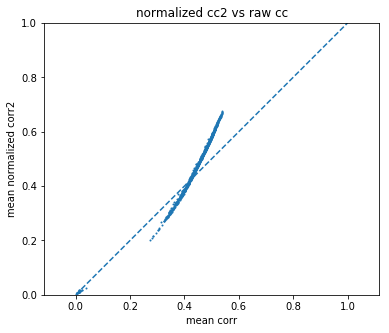

y-x mean 0.032950481816303855 y-x>0 mean 0.7065972222222222
y top 0.6752014015164023 x top 0.5400376915931702
0.9599189959335681


In [14]:
# correlation between corr_test, and corr2_normed_test
scatter(df['corr_test'].values, df['corr2_normed_test'].values, 'mean corr', 'mean normalized corr2', 'normalized cc2 vs raw cc')

# ok. good. so my previous measures still hold.

from scipy.stats import pearsonr
print(pearsonr(df['corr_test'].values, df['corr2_normed_test'].values)[0])

In [15]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack):
    df_unstacked = series_in.unstack(label_to_unstack)
    assert df_unstacked.shape[1] == 2
    labels = [str(x) for x in df_unstacked.columns.values]
    assert len(labels) == 2
    scatter(df_unstacked.values[:,0], df_unstacked.values[:,1], labels[0], labels[1], label_to_unstack)
    
    
    

In [16]:
def check_stuffs(df_in, check_size, field_to_check='corr_test'):
    
    # comments inside this function were based on `df_in` set to the input_size=100 case (`df_2x`).
    # seems that some results don't hold for df_4x (input_size=50).
    # tricky.
    
    if check_size:
        # only check high performing ones.
#         df_clean = df_in['corr_test'].unstack('input_size')
#         df_clean = df_clean[(df_clean > 0.4).any(axis=1)].stack('input_size')
#         check_compare_one_case(df_clean, 'input_size')
        check_compare_one_case(df_in[field_to_check], 'input_size')

    check_compare_one_case(df_in[field_to_check], 'act_fn')

    check_compare_one_case(df_in[field_to_check], 'bn_before_act')
    # due to those outliers when bn_before_act is True, maybe simply stick to bn_before_act=False.

    check_compare_one_case(df_in[field_to_check], 'bn_after_fc')
    # use False just to be safe.
    
    check_compare_one_case(df_in[field_to_check], 'loss_type')

    # check smoothness
    check_compare_one_case(pd.concat([df_in.xs(5e-6, level='smoothness', drop_level=False),
                                      df_in.xs(5e-5, level='smoothness', drop_level=False)],
                                     axis=0)[field_to_check],
                           'smoothness')
    # almost the same. seems 5e-6 a bit more stable.

    check_compare_one_case(pd.concat([df_in.xs(5e-6, level='smoothness', drop_level=False),
                                      df_in.xs(5e-4, level='smoothness', drop_level=False)],
                                     axis=0)[field_to_check],
                           'smoothness')


    check_compare_one_case(pd.concat([df_in.xs(5e-6, level='smoothness', drop_level=False),
                                      df_in.xs(5e-3, level='smoothness', drop_level=False)],
                                     axis=0)[field_to_check],
                           'smoothness')

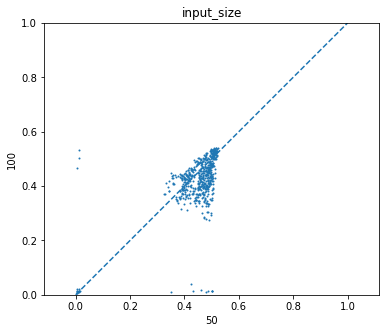

y-x mean -0.027794304381145385 y-x>0 mean 0.3958333333333333
y top 0.5400376915931702 x top 0.5227528810501099


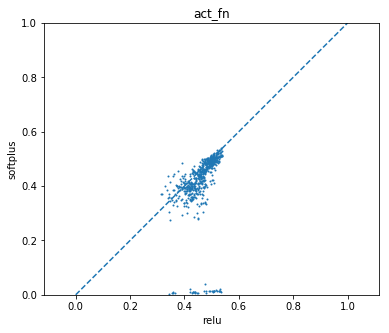

y-x mean -0.04727736544732329 y-x>0 mean 0.2482638888888889
y top 0.5383689999580383 x top 0.5400376915931702


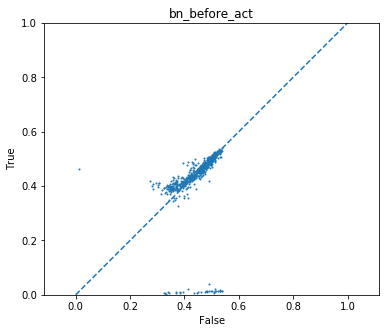

y-x mean -0.01588495616982043 y-x>0 mean 0.6163194444444444
y top 0.5391941666603088 x top 0.5400376915931702


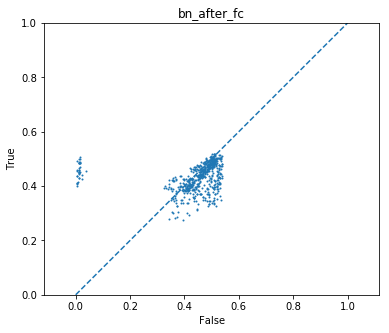

y-x mean -0.0027100121594995545 y-x>0 mean 0.25
y top 0.5189763903617859 x top 0.5400376915931702


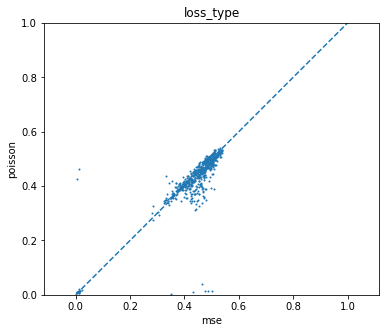

y-x mean -0.010670746265172127 y-x>0 mean 0.4461805555555556
y top 0.5383689999580383 x top 0.5400376915931702


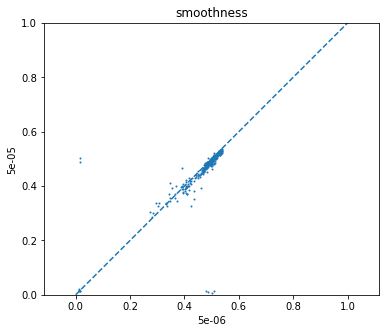

y-x mean -0.009837173805283662 y-x>0 mean 0.21875
y top 0.5359396934509277 x top 0.5400376915931702


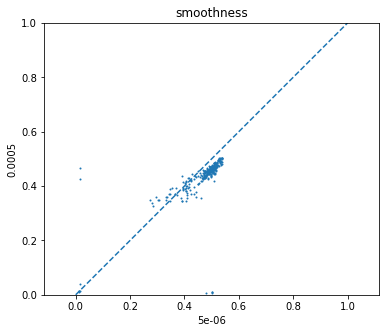

y-x mean -0.033381612462234665 y-x>0 mean 0.10416666666666667
y top 0.5049631595611572 x top 0.5400376915931702


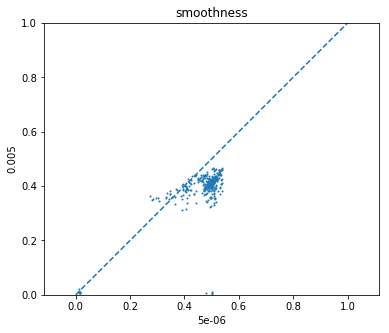

y-x mean -0.07521740545523131 y-x>0 mean 0.0763888888888889
y top 0.4680382013320923 x top 0.5400376915931702


In [17]:
check_stuffs(df, check_size=True)
# for input size, seems that 100 is better than 50 for state-of-the-art, but worse in general.

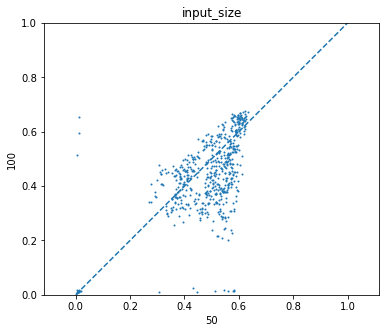

y-x mean -0.043865741706041204 y-x>0 mean 0.4131944444444444
y top 0.6752014015164023 x top 0.6326211607296514


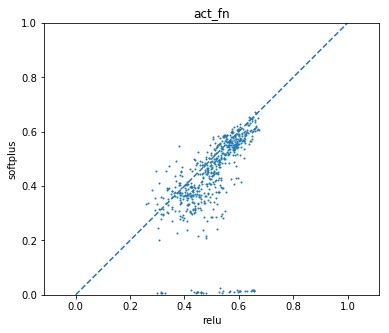

y-x mean -0.06765346513862597 y-x>0 mean 0.2361111111111111
y top 0.670868675454237 x top 0.6752014015164023


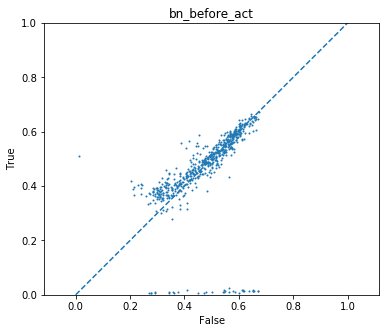

y-x mean -0.011930752902336087 y-x>0 mean 0.6284722222222222
y top 0.6724661678275416 x top 0.6752014015164023


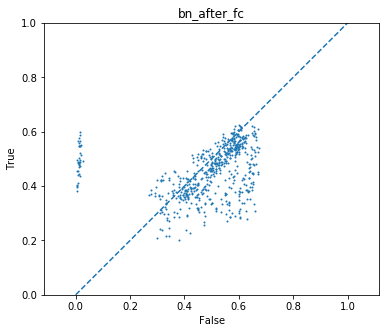

y-x mean -0.03006049537403553 y-x>0 mean 0.2482638888888889
y top 0.6243307445703443 x top 0.6752014015164023


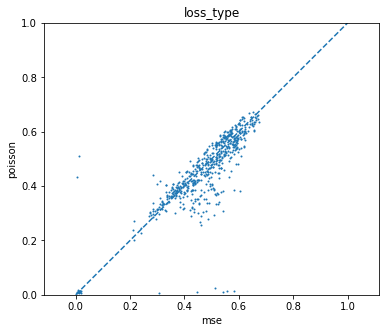

y-x mean -0.016879927062648695 y-x>0 mean 0.4461805555555556
y top 0.670868675454237 x top 0.6752014015164023


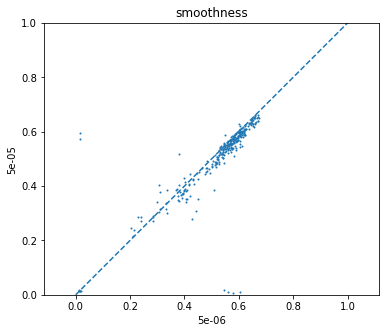

y-x mean -0.017465311852563073 y-x>0 mean 0.19444444444444445
y top 0.6633120285127625 x top 0.6752014015164023


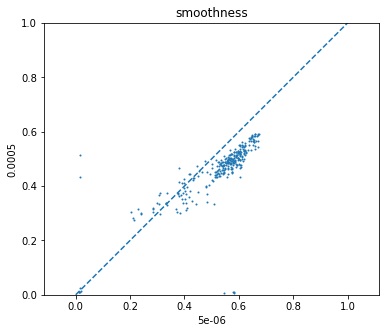

y-x mean -0.06711590443181284 y-x>0 mean 0.10069444444444445
y top 0.5930359302688875 x top 0.6752014015164023


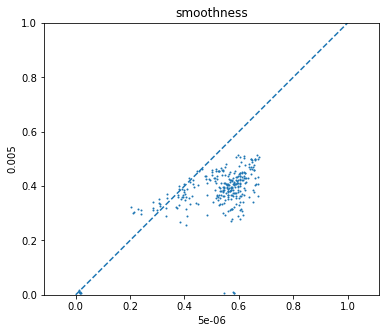

y-x mean -0.14460785582433408 y-x>0 mean 0.0798611111111111
y top 0.5161059665126956 x top 0.6752014015164023


In [18]:
check_stuffs(df, check_size=True, field_to_check='corr2_normed_test')

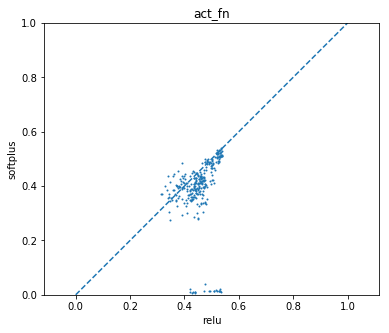

y-x mean -0.06271074738172114 y-x>0 mean 0.2152777777777778
y top 0.5383689999580383 x top 0.5400376915931702


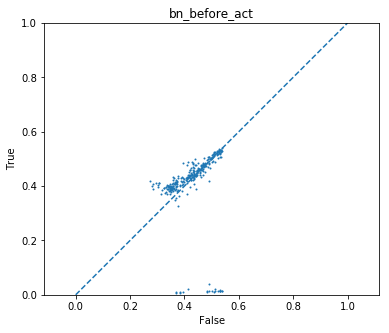

y-x mean -0.01425954515962613 y-x>0 mean 0.7083333333333334
y top 0.5391941666603088 x top 0.5400376915931702


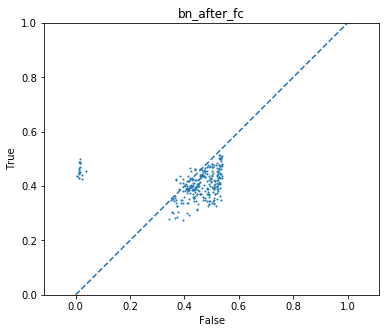

y-x mean -0.02462233497922919 y-x>0 mean 0.1423611111111111
y top 0.5160986185073853 x top 0.5400376915931702


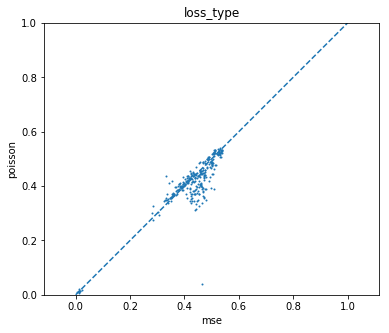

y-x mean -0.015259988526984378 y-x>0 mean 0.4444444444444444
y top 0.5383689999580383 x top 0.5400376915931702


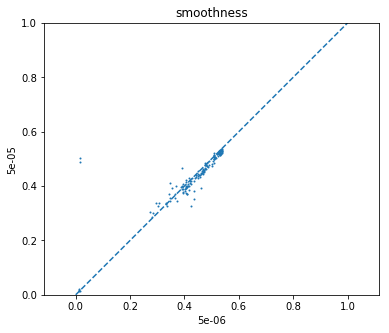

y-x mean 0.0003129383288756145 y-x>0 mean 0.2777777777777778
y top 0.5359396934509277 x top 0.5400376915931702


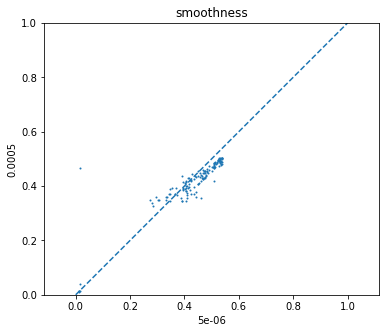

y-x mean -0.01741117543364716 y-x>0 mean 0.2013888888888889
y top 0.5049631595611572 x top 0.5400376915931702


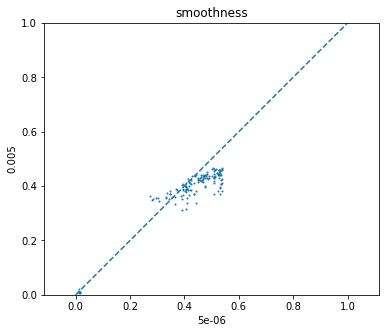

y-x mean -0.041584813783166155 y-x>0 mean 0.1527777777777778
y top 0.4680382013320923 x top 0.5400376915931702


In [19]:
df_2x = df.xs(100, level='input_size')
check_stuffs(df_2x, check_size=False)

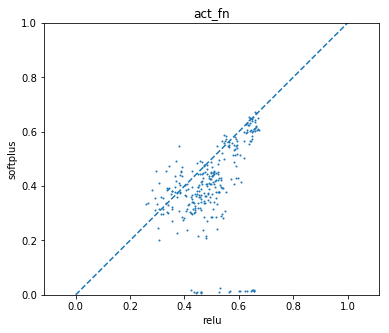

y-x mean -0.09351963203931461 y-x>0 mean 0.2048611111111111
y top 0.670868675454237 x top 0.6752014015164023


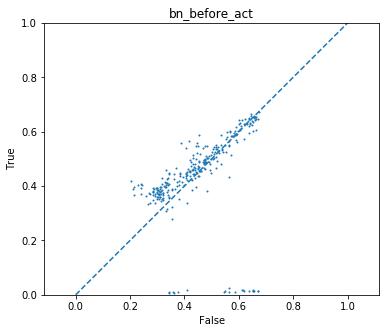

y-x mean -0.006473941350841915 y-x>0 mean 0.71875
y top 0.6724661678275416 x top 0.6752014015164023


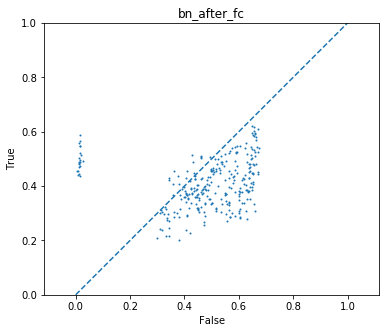

y-x mean -0.07344404641335175 y-x>0 mean 0.13194444444444445
y top 0.620832293051585 x top 0.6752014015164023


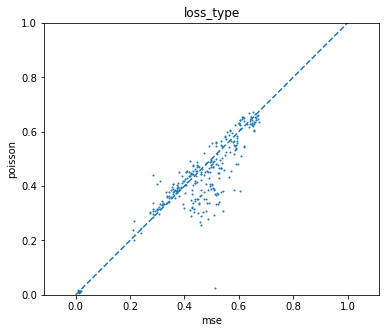

y-x mean -0.02612503790003851 y-x>0 mean 0.4409722222222222
y top 0.670868675454237 x top 0.6752014015164023


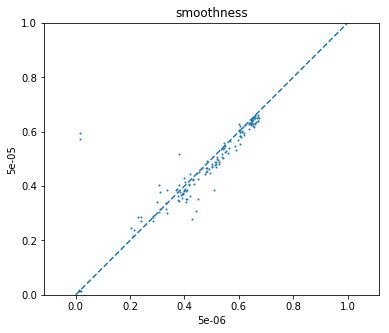

y-x mean -0.005610858664976751 y-x>0 mean 0.2361111111111111
y top 0.6633120285127625 x top 0.6752014015164023


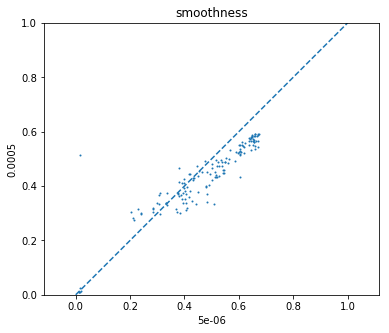

y-x mean -0.04109077132640544 y-x>0 mean 0.19444444444444445
y top 0.5930359302688875 x top 0.6752014015164023


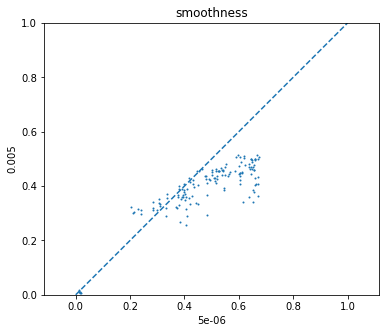

y-x mean -0.08642418772007521 y-x>0 mean 0.1597222222222222
y top 0.5161059665126956 x top 0.6752014015164023


In [20]:
check_stuffs(df_2x, check_size=False, field_to_check='corr2_normed_test')

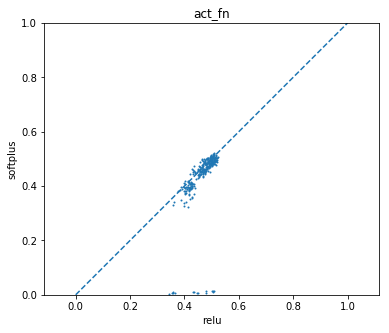

y-x mean -0.03184398351292546 y-x>0 mean 0.28125
y top 0.5199894309043884 x top 0.5227528810501099


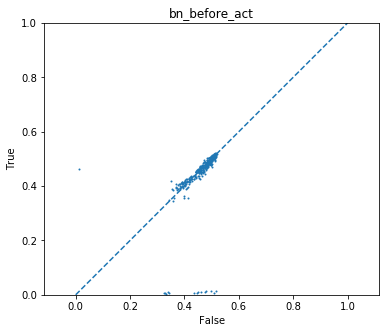

y-x mean -0.017510367180014735 y-x>0 mean 0.5243055555555556
y top 0.5227528810501099 x top 0.5182023644447327


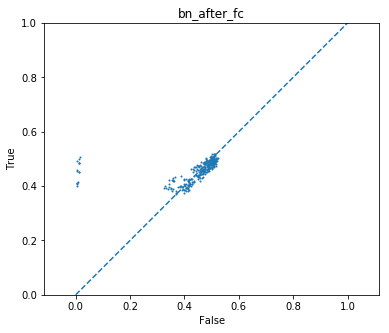

y-x mean 0.01920231066023008 y-x>0 mean 0.3576388888888889
y top 0.5189763903617859 x top 0.5227528810501099


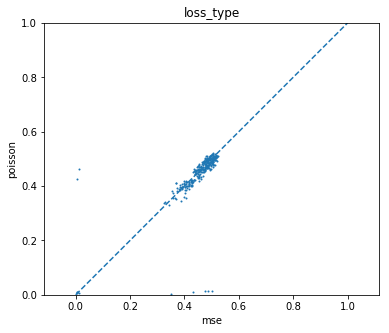

y-x mean -0.006081504003359876 y-x>0 mean 0.4479166666666667
y top 0.5199894309043884 x top 0.5227528810501099


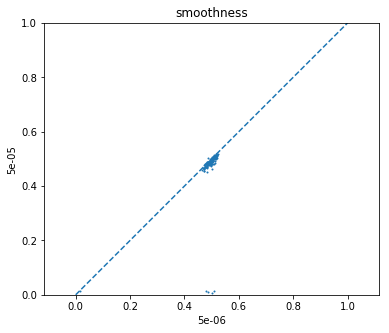

y-x mean -0.01998728593944294 y-x>0 mean 0.1597222222222222
y top 0.5178518891334534 x top 0.5227528810501099


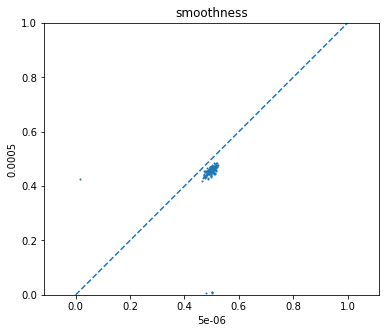

y-x mean -0.049352049490822156 y-x>0 mean 0.006944444444444444
y top 0.4850822985172272 x top 0.5227528810501099


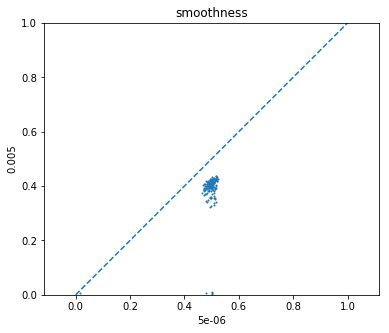

y-x mean -0.1088499971272965 y-x>0 mean 0.0
y top 0.4379729628562927 x top 0.5227528810501099


In [21]:
df_4x = df.xs(50, level='input_size')
check_stuffs(df_4x, check_size=False)

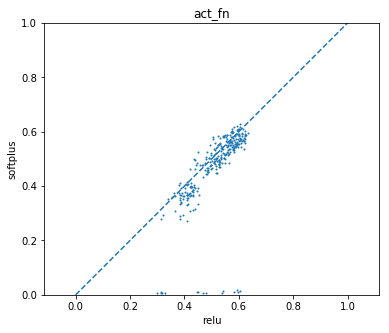

y-x mean -0.04178729823793733 y-x>0 mean 0.2673611111111111
y top 0.6268537783966928 x top 0.6326211607296514


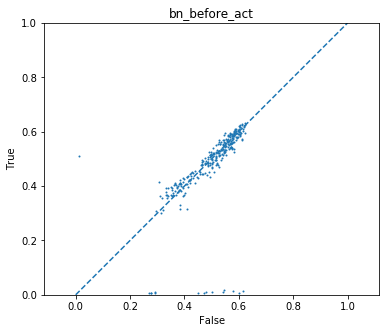

y-x mean -0.01738756445383026 y-x>0 mean 0.5381944444444444
y top 0.6326211607296514 x top 0.6230526634247663


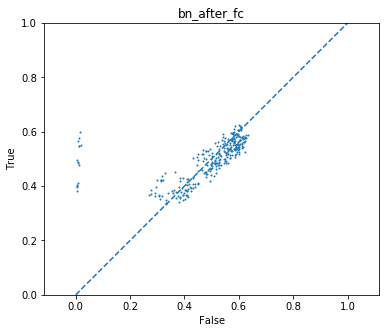

y-x mean 0.013323055665280695 y-x>0 mean 0.3645833333333333
y top 0.6243307445703443 x top 0.6326211607296514


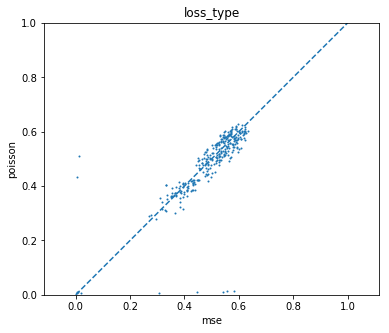

y-x mean -0.007634816225258887 y-x>0 mean 0.4513888888888889
y top 0.6268537783966928 x top 0.6326211607296514


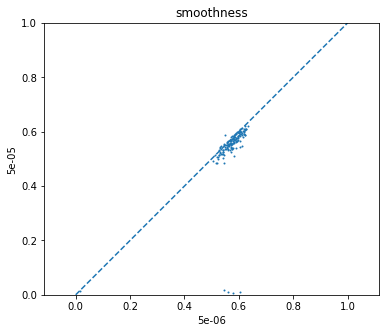

y-x mean -0.029319765040149395 y-x>0 mean 0.1527777777777778
y top 0.6211436527215012 x top 0.6326211607296514


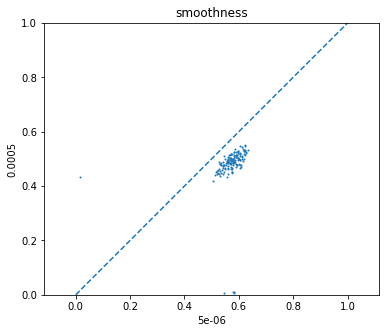

y-x mean -0.09314103753722022 y-x>0 mean 0.006944444444444444
y top 0.550048373211427 x top 0.6326211607296514


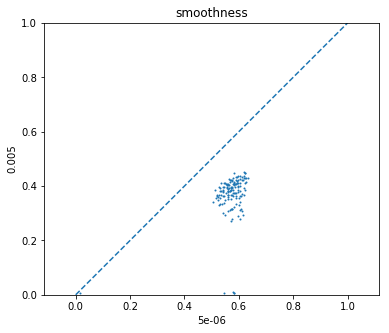

y-x mean -0.202791523928593 y-x>0 mean 0.0
y top 0.45313060178963604 x top 0.6326211607296514


In [22]:
check_stuffs(df_4x, check_size=False, field_to_check='corr2_normed_test')

In [23]:
# so pick 5e-6
df_2x_small_smooth = df_2x.xs(5e-6, level='smoothness')

In [24]:
df_2x_small_smooth['corr_test'].unstack('scale')
# this is mixed result.

scale                                                       0.001     0.010  \
split_seed act_fn   bn_before_act bn_after_fc loss_type                       
0          relu     False         False       mse        0.477402  0.525837   
                                              poisson    0.450775  0.530209   
                                  True        mse        0.448857  0.460479   
                                              poisson    0.407786  0.406804   
                    True          False       mse        0.477053  0.530710   
                                              poisson    0.460360  0.521664   
                                  True        mse        0.454697  0.472807   
                                              poisson    0.370769  0.423352   
           softplus False         False       mse        0.343267  0.491091   
                                              poisson    0.410165  0.507856   
                                  True        mse        0.280433  0.333605   
                                              poisson    0.302380  0.348094   
                    True          False       mse        0.401285  0.508183   
                                              poisson    0.424529  0.524554   
                                  True        mse        0.401107  0.395547   
                                              poisson    0.405140  0.406236   
1          relu     False         False       mse        0.482912  0.540038   
                                              poisson    0.465864  0.523455   
                                  True        mse        0.469268  0.480127   
                                              poisson    0.392733  0.390118   
                    True          False       mse        0.484219  0.539194   
                                              poisson    0.471054  0.528635   
                                  True        mse        0.456425  0.472389   
                                              poisson    0.405757  0.434180   
           softplus False         False       mse        0.352846  0.509489   
                                              poisson    0.418144  0.518815   
                                  True        mse        0.305999  0.333597   
                                              poisson    0.294655  0.436089   
                    True          False       mse        0.394879  0.512848   
                                              poisson    0.434343  0.528940   
                                  True        mse        0.411822  0.396580   
                                              poisson    0.409860  0.406746   
legacy     relu     False         False       mse        0.469303  0.526081   
                                              poisson    0.467179  0.531430   
                                  True        mse        0.451390  0.467048   
                                              poisson    0.347466  0.364602   
                    True          False       mse        0.476325  0.537495   
                                              poisson    0.441894  0.534274   
                                  True        mse        0.466383  0.480816   
                                              poisson    0.387896  0.348486   
           softplus False         False       mse        0.366474  0.510227   
                                              poisson    0.395833  0.511821   
                                  True        mse        0.283901  0.336360   
                                              poisson    0.273488  0.372271   
                    True          False       mse        0.405931  0.510171   
                                              poisson    0.417262  0.526263   
                                  True        mse        0.408418  0.404878   
                                              poisson    0.419921  0.415973   

scale                                            

In [25]:
df_2x_small_smooth['corr_test'].unstack('act_fn')
# ha, so actually ReLU works!!! my previous experiments were not good.

act_fn                                                    relu  softplus
split_seed bn_before_act bn_after_fc loss_type scale                    
0          False         False       mse       0.001  0.477402  0.343267
                                               0.010  0.525837  0.491091
                                               0.100  0.532714  0.521709
                                     poisson   0.001  0.450775  0.410165
                                               0.010  0.530209  0.507856
                                               0.100  0.535056  0.537748
                         True        mse       0.001  0.448857  0.280433
                                               0.010  0.460479  0.333605
                                               0.100  0.500410  0.421671
                                     poisson   0.001  0.407786  0.302380
                                               0.010  0.406804  0.348094
                                               0.100  0.444160  0.429406
           True          False       mse       0.001  0.477053  0.401285
                                               0.010  0.530710  0.508183
                                               0.100  0.531642  0.013282
                                     poisson   0.001  0.460360  0.424529
                                               0.010  0.521664  0.524554
                                               0.100  0.508153  0.013075
                         True        mse       0.001  0.454697  0.401107
                                               0.010  0.472807  0.395547
                                               0.100  0.513059  0.458655
                                     poisson   0.001  0.370769  0.405140
                                               0.010  0.423352  0.406236
                                               0.100  0.475937  0.488182
1          False         False       mse       0.001  0.482912  0.352846
                                               0.010  0.540038  0.509489
                                               0.100  0.538532  0.529549
                                     poisson   0.001  0.465864  0.418144
                                               0.010  0.523455  0.518815
                                               0.100  0.534565  0.538369
                         True        mse       0.001  0.469268  0.305999
                                               0.010  0.480127  0.333597
                                               0.100  0.509991  0.413066
                                     poisson   0.001  0.392733  0.294655
                                               0.010  0.390118  0.436089
                                               0.100  0.462618  0.437631
           True          False       mse       0.001  0.484219  0.394879
                                               0.010  0.539194  0.512848
                                               0.100  0.528559  0.014455
                                     poisson   0.001  0.471054  0.434343
                                               0.010  0.528635  0.528940
                                               0.100  0.527031  0.014149
                         True        mse       0.001  0.456425  0.411822
                                               0.010  0.472389  0.396580
                                               0.100  0.516099  0.489857
                                     poisson   0.001  0.405757  0.409860
                                               0.010  0.434180  0.406746
                                               0.100  0.476298  0.500435
legacy     False         False       mse       0.001  0.469303  0.366474
                                               0.010  0.526081  0.510227
                                               0.100  0.534385  0.509220
                                     poisson   0.001  0.467179  0.395833
                                               0.010  0.53

In [26]:
df_2x_small_smooth['corr_test'].unstack('split_seed')
# seems consistent. just focus on one seed.

split_seed                                                 0         1  \
act_fn   bn_before_act bn_after_fc loss_type scale                       
relu     False         False       mse       0.001  0.477402  0.482912   
                                             0.010  0.525837  0.540038   
                                             0.100  0.532714  0.538532   
                                   poisson   0.001  0.450775  0.465864   
                                             0.010  0.530209  0.523455   
                                             0.100  0.535056  0.534565   
                       True        mse       0.001  0.448857  0.469268   
                                             0.010  0.460479  0.480127   
                                             0.100  0.500410  0.509991   
                                   poisson   0.001  0.407786  0.392733   
                                             0.010  0.406804  0.390118   
                                             0.100  0.444160  0.462618   
         True          False       mse       0.001  0.477053  0.484219   
                                             0.010  0.530710  0.539194   
                                             0.100  0.531642  0.528559   
                                   poisson   0.001  0.460360  0.471054   
                                             0.010  0.521664  0.528635   
                                             0.100  0.508153  0.527031   
                       True        mse       0.001  0.454697  0.456425   
                                             0.010  0.472807  0.472389   
                                             0.100  0.513059  0.516099   
                                   poisson   0.001  0.370769  0.405757   
                                             0.010  0.423352  0.434180   
                                             0.100  0.475937  0.476298   
softplus False         False       mse       0.001  0.343267  0.352846   
                                             0.010  0.491091  0.509489   
                                             0.100  0.521709  0.529549   
                                   poisson   0.001  0.410165  0.418144   
                                             0.010  0.507856  0.518815   
                                             0.100  0.537748  0.538369   
                       True        mse       0.001  0.280433  0.305999   
                                             0.010  0.333605  0.333597   
                                             0.100  0.421671  0.413066   
                                   poisson   0.001  0.302380  0.294655   
                                             0.010  0.348094  0.436089   
                                             0.100  0.429406  0.437631   
         True          False       mse       0.001  0.401285  0.394879   
                                             0.010  0.508183  0.512848   
                                             0.100  0.013282  0.014455   
                                   poisson   0.001  0.424529  0.434343   
                                             0.010  0.524554  0.528940   
                                             0.100  0.013075  0.014149   
                       True        mse       0.001  0.401107  0.411822   
                                             0.010  0.395547  0.396580   
                                             0.100  0.458655  0.489857   
                                   poisson   0.001  0.405140  0.409860   
                                             0.010  0.406236  0.406746   
                                             0.100  0.488182  0.500435   

split_seed                                            legacy  
act_fn   bn_before_act bn_after_fc loss_type scale            
relu     False         False       mse       0.001  0.469303  
                                             0.010  0.526081  
                                             0.

In [27]:
df_2x_small_smooth_legacy_seed = df_2x_small_smooth.xs('legacy', level='split_seed')

In [28]:
df_2x_small_smooth_legacy_seed['corr_test'].unstack('scale').unstack('act_fn')
# relu most of the time works better.

scale                                   0.001               0.010            \
act_fn                                   relu  softplus      relu  softplus   
bn_before_act bn_after_fc loss_type                                           
False         False       mse        0.469303  0.366474  0.526081  0.510227   
                          poisson    0.467179  0.395833  0.531430  0.511821   
              True        mse        0.451390  0.283901  0.467048  0.336360   
                          poisson    0.347466  0.273488  0.364602  0.372271   
True          False       mse        0.476325  0.405931  0.537495  0.510171   
                          poisson    0.441894  0.417262  0.534274  0.526263   
              True        mse        0.466383  0.408418  0.480816  0.404878   
                          poisson    0.387896  0.419921  0.348486  0.415973   

scale                                   0.100            
act_fn                                   relu  softplus  
bn_before_act bn_after_fc loss_type                      
False         False       mse        0.534385  0.509220  
                          poisson    0.532006  0.532022  
              True        mse        0.504570  0.422372  
                          poisson    0.443523  0.449763  
True          False       mse        0.533001  0.010831  
                          poisson    0.507949  0.014625  
              True        mse        0.507834  0.466877  
                          poisson    0.390707  0.483318

In [29]:
df_2x_small_smooth_legacy_seed['corr_test'].unstack('bn_before_act')
# switching BN and act has mixed results. maybe best switch it (as done in modern CNNs), due to less fluctuation.

bn_before_act                            False     True 
act_fn   bn_after_fc loss_type scale                    
relu     False       mse       0.001  0.469303  0.476325
                               0.010  0.526081  0.537495
                               0.100  0.534385  0.533001
                     poisson   0.001  0.467179  0.441894
                               0.010  0.531430  0.534274
                               0.100  0.532006  0.507949
         True        mse       0.001  0.451390  0.466383
                               0.010  0.467048  0.480816
                               0.100  0.504570  0.507834
                     poisson   0.001  0.347466  0.387896
                               0.010  0.364602  0.348486
                               0.100  0.443523  0.390707
softplus False       mse       0.001  0.366474  0.405931
                               0.010  0.510227  0.510171
                               0.100  0.509220  0.010831
                     poisson   0.001  0.395833  0.417262
                               0.010  0.511821  0.526263
                               0.100  0.532022  0.014625
         True        mse       0.001  0.283901  0.408418
                               0.010  0.336360  0.404878
                               0.100  0.422372  0.466877
                     poisson   0.001  0.273488  0.419921
                               0.010  0.372271  0.415973
                               0.100  0.449763  0.483318

In [30]:
df_2x_small_smooth_legacy_seed['corr_test'].unstack('bn_after_fc')
# having bn_output is mostly bad. forget it.

bn_after_fc                                False     True 
act_fn   bn_before_act loss_type scale                    
relu     False         mse       0.001  0.469303  0.451390
                                 0.010  0.526081  0.467048
                                 0.100  0.534385  0.504570
                       poisson   0.001  0.467179  0.347466
                                 0.010  0.531430  0.364602
                                 0.100  0.532006  0.443523
         True          mse       0.001  0.476325  0.466383
                                 0.010  0.537495  0.480816
                                 0.100  0.533001  0.507834
                       poisson   0.001  0.441894  0.387896
                                 0.010  0.534274  0.348486
                                 0.100  0.507949  0.390707
softplus False         mse       0.001  0.366474  0.283901
                                 0.010  0.510227  0.336360
                                 0.100  0.509220  0.422372
                       poisson   0.001  0.395833  0.273488
                                 0.010  0.511821  0.372271
                                 0.100  0.532022  0.449763
         True          mse       0.001  0.405931  0.408418
                                 0.010  0.510171  0.404878
                                 0.100  0.010831  0.466877
                       poisson   0.001  0.417262  0.419921
                                 0.010  0.526263  0.415973
                                 0.100  0.014625  0.483318